# Определение возраста покупателей

**Заказчик**: Интернет-магазин «Викишоп» 

**Контекст**: Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы, а также чтобы контролировать добросовестность кассиров при продаже алкоголя.

**Цель проекта**: Построить модель, которая по фотографии определит приблизительный возраст человека со значением метрики MAE не больше 8

**План проекта**:  
- [Исследовательский анализ данных](#1)
- [Обучение модеди](#2)
- [Анализ модели](#3)
- [Вывод](4)

## Исследовательский анализ данных <a id='1'> </a>

In [1]:
#импорт библиотек
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
#инициируем класс
train_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
#извлечем данные из папки
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Далее проведем исследовательский анализ.

1) Посмотрим на размер выборки:

In [5]:
labels.shape

(7591, 2)

Заметим, папка содержит `7591` фотографию.

2) Построим распределение возраста в выборке:

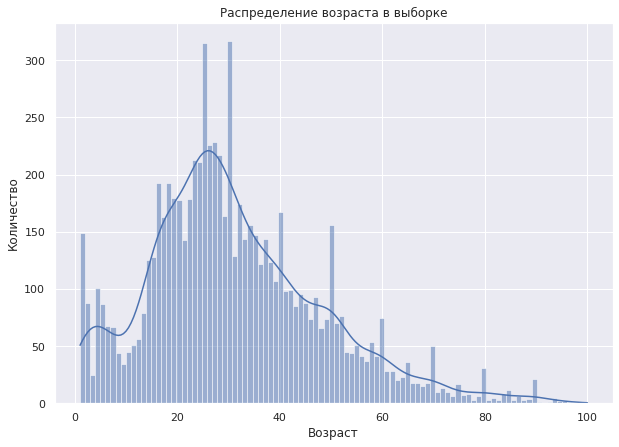

In [6]:
#построим график распределения возраста в выборке

sns.set_theme(rc={'figure.figsize':(10,7)})
ax = sns.histplot(data=labels['real_age'], bins=100, kde=True)
ax.set_xlabel('Возраст')
ax.set_ylabel('Количество')
ax.set_title('Распределение возраста в выборке');

In [7]:
#выведем основные статистики по возрасту
display(pd.DataFrame(labels['real_age'].describe()))

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [8]:
#напечатае моду выборки
labels['real_age'].mode()

0    30
dtype: int64

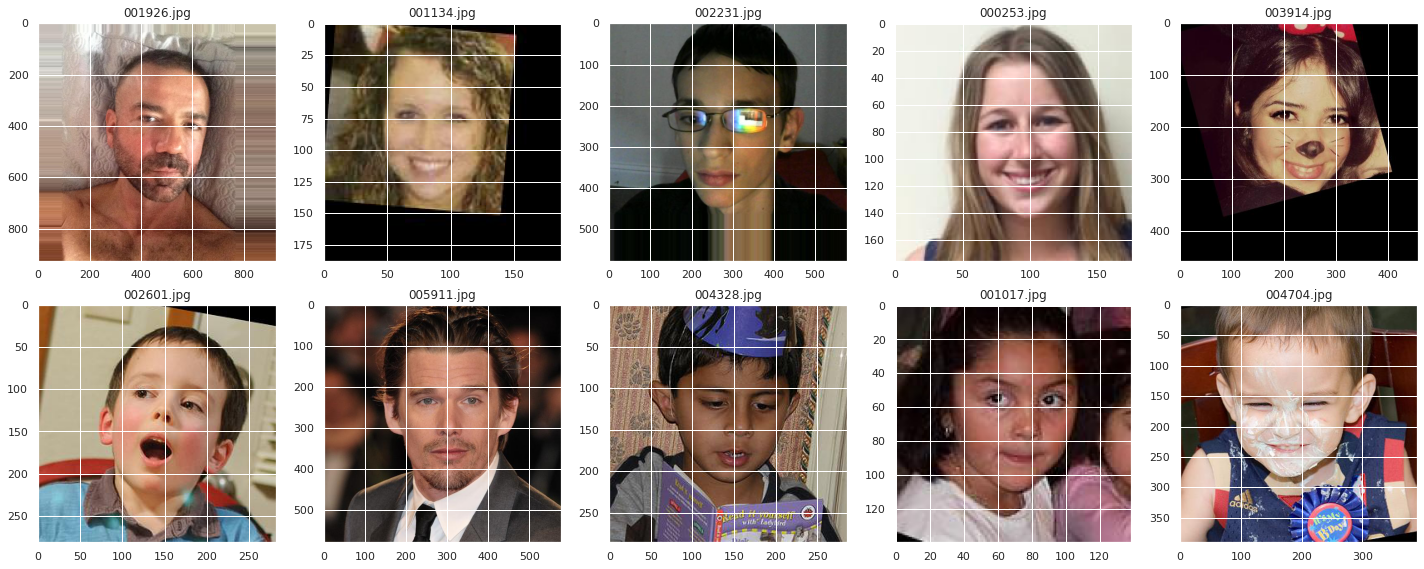

In [9]:
#напечатаем 10 случайный фотограйи, чтобы понять, как устроен датасет
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

for ax_row in axes:
    for ax, filename in zip(ax_row, labels['file_name'].sample(10)):
        image = Image.open('/datasets/faces/final_files/' + filename)
        ax.imshow(image)
        ax.set_title(filename)

plt.tight_layout()
plt.show()

Мини-вывод:
- присутствуют пики в районе "юбилейных" лет, они тут могут быть связаны с тем, что настоящий возраст был неизвестен тому, кто размечал датасет, и он попросту округлял его.
- возраст имеет `относительно нормальное распределение`, однако можно выделить несколько вершин. Основная вершина - `около 30 лет`, это самый частый возраст в выборке. Второстепенная вершина - возраст примерно от 1 до 5, то есть маленький детей.
- самый большой возраст в выборке - `100 лет`, самый маленький - `1 год`
- фотографии цветные и черно-белые разных размеров, ориентация правильная

## Обучение модели <a id='2'> </a>

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import os

optimizer = Adam(lr=0.0001)
 
def load_train(path):
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255, vertical_flip=True)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(os.path.join(path, 'labels.csv')),
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    
    return train_gen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(os.path.join(path, 'labels.csv')),
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    
    return test_gen_flow
 
def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mean_absolute_error'])

    return model
 
 

def train_model(model, train_data, test_data, batch_size=None, epochs=8,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

```

2024-04-27 17:30:27.884686: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2024-04-27 17:30:27.886574: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2024-04-27 17:30:28.805677: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-04-27 17:30:28.814400: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2024-04-27 17:30:28.814451: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-04-27 17:30:28.814481: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-04-27 17:30:28.816347: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2024-04-27 17:30:28.816720: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2024-04-27 17:30:28.818648: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2024-04-27 17:30:28.819759: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2024-04-27 17:30:28.819814: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-04-27 17:30:28.822524: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2024-04-27 17:30:28.993340: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2024-04-27 17:30:28.999488: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099990000 Hz
2024-04-27 17:30:28.999977: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4df5cb0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-04-27 17:30:28.999999: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-04-27 17:30:29.183953: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4455fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-27 17:30:29.183985: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2024-04-27 17:30:29.185557: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2024-04-27 17:30:29.185616: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-04-27 17:30:29.185626: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-04-27 17:30:29.185651: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2024-04-27 17:30:29.185660: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2024-04-27 17:30:29.185669: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2024-04-27 17:30:29.185677: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2024-04-27 17:30:29.185684: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-04-27 17:30:29.188735: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2024-04-27 17:30:29.188800: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-04-27 17:30:29.851313: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-04-27 17:30:29.851357: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2024-04-27 17:30:29.851364: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2024-04-27 17:30:29.854269: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-04-27 17:30:29.854314: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/8
2024-04-27 17:30:42.090660: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-04-27 17:30:42.548483: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 64s - loss: 261.3218 - mean_absolute_error: 11.7485 - val_loss: 823.5618 - val_mean_absolute_error: 23.8058
Epoch 2/8
178/178 - 49s - loss: 95.3619 - mean_absolute_error: 7.3689 - val_loss: 667.4889 - val_mean_absolute_error: 20.8442
Epoch 3/8
178/178 - 38s - loss: 65.8381 - mean_absolute_error: 6.1397 - val_loss: 337.4332 - val_mean_absolute_error: 13.7609
Epoch 4/8
178/178 - 37s - loss: 46.9095 - mean_absolute_error: 5.1939 - val_loss: 122.1258 - val_mean_absolute_error: 8.4935
Epoch 5/8
178/178 - 37s - loss: 37.0110 - mean_absolute_error: 4.5492 - val_loss: 96.0241 - val_mean_absolute_error: 7.5157
Epoch 6/8
178/178 - 38s - loss: 29.4822 - mean_absolute_error: 4.1489 - val_loss: 87.2899 - val_mean_absolute_error: 7.3096
Epoch 7/8
178/178 - 37s - loss: 24.6116 - mean_absolute_error: 3.7369 - val_loss: 72.6376 - val_mean_absolute_error: 6.4244
Epoch 8/8
178/178 - 37s - loss: 19.3869 - mean_absolute_error: 3.3918 - val_loss: 83.9721 - val_mean_absolute_error: 7.1311
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 83.9721 - mean_absolute_error: 7.1311
Test MAE: 7.1311


```

## Анализ обученной модели <a id='3'> </a>

Итоговый MAE на тестовой выборке - 7,13, однако на 7 эпохе MAE на тестовой выборке был выше, после начал падать при том что на тренирочной выборке метрика росла. Следоватлеьно, имеет место переобучение модели. Тем не менее, требование поставленной цели выполняется - метрика <= 8.

## Вывод <a id='4'> </a>

Данные:
- присутствуют пики в районе "юбилейных" лет, они тут могут быть связаны с тем, что настоящий возраст был неизвестен тому, кто размечал датасет, и он попросту округлял его.
- возраст имеет `относительно нормальное распределение`, однако можно выделить несколько вершин. Основная вершина - `около 30 лет`, это самый частый возраст в выборке. Второстепенная вершина - возраст примерно от 1 до 5, то есть маленький детей.
- самый большой возраст в выборке - `100 лет`, самый маленький - `1 год`
- фотографии цветные и черно-белые разных размеров, ориентация правильная

Модель:
- Была обучена модел, которая по фотографии определит приблизительный возраст человека 
- Итоговый MAE на тестовой выборке - 7,13, однако на 7 эпохе MAE на тестовой выборке был выше, после начал падать при том что на тренирочной выборке метрика росла. Следоватлеьно, имеет место переобучение модели. Тем не менее, требование поставленной цели выполняется - метрика <= 8.